# Design Project 2

This notebook makes use of [SymPy](https://docs.sympy.org/), which is a Python library for symbolic mathematics.

In [1]:
import sympy as sym
import numpy as np
from sympy.physics import mechanics
from sympy import *
from scipy import linalg

# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import matplotlib.pyplot as plt

import ae353_segbot

import importlib
importlib.reload(ae353_segbot)

pybullet build time: Jan 28 2022 20:18:15


<module 'ae353_segbot' from '/Users/bellawatters/Documents/ae353-sp22/projects/02_segbot/ae353_segbot.py'>

## Equation of Motion Derivation

Most of this derivation comes directly from Dr. Bretl's repository https://github.com/tbretl/ae353-sp22/tree/main/projects/02_segbot

Define physical constants, consistent with the URDF file:

In [2]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

Convert all physical constants to rational numbers:

In [3]:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

Define variables (with a flag to indicate they are all real numbers — this helps simplify):

In [4]:
(e_l,
 e_h,
 v1,
 v2,
 w,
 theta,
 tau_R,
 tau_L) = sym.symbols('e_l, e_h, v1, v2, w, theta, tau_R, tau_L', real=True)

Compute equations of motion, excluding lateral and heading errors (see [Tuttle, 2014](https://docs.lib.purdue.edu/cgi/viewcontent.cgi?article=1415&context=open_access_theses)):

In [5]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + v2**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * v2 - mb * h * sym.sin(theta) * v1 * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f1 = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))


In [6]:
M

Matrix([
[           78/5,                                                            0, 18*cos(theta)/5],
[              0, 4289*sin(theta)**2/2000 + 1169*cos(theta)**2/2000 + 441/1000,               0],
[18*cos(theta)/5,                                                            0,         108/125]])

In [7]:
N

Matrix([
[                       (18*v2**2/5 + 18*w**2/5)*sin(theta)],
[-18*v1*w*sin(theta)/5 - 444*v2*w*sin(theta)*cos(theta)/125],
[          39*w**2*sin(theta)*cos(theta)/25 + 18*sin(theta)]])

In [8]:
R

Matrix([
[ 40/13, 40/13],
[-14/13, 14/13],
[    -1,    -1]])

Compute full equations of motion:

In [9]:
f = sym.Matrix([[v1 * sym.sin(e_h)],
                [w],
                [f1]])

Display the vector-valued function $f$ for which the equations of motion can be written as

$$\begin{bmatrix} \dot{e}_\text{lateral} \\ \dot{e}_\text{heading} \\ \dot{v} \\ \dot{w} \\ \ddot{\theta} \end{bmatrix} = f(e_\text{lateral}, e_\text{heading}, v, w, \theta, \dot{\theta}, \tau_R, \tau_L)$$

In [10]:
f

Matrix([
[                                                                                                                                                                    v1*sin(e_h)],
[                                                                                                                                                                              w],
[        -(1200*tau_L + 1200*tau_R + 1404*(v2**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                   32*(-875*tau_L + 875*tau_R - 2925*v1*w*sin(theta) - 1443*v2*w*sin(2*theta))/(13*(3120*sin(theta)**2 + 2051))],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(v2**2 + w**2)*sin(theta))*cos(theta) - 76050*sin(theta))/(702*(25*cos(theta)**2 - 26))]])

Note that one of these ODEs is second-order — you will have to replace this with a set of two first-order ODEs, as usual.

## Linearization

We will linearize the system using a state-space model.

Our state is defined,
$$x = \left[\begin{matrix}e_{lat} - e_{lat,e}\\e_{head} - e_{head,e}\\v_1 - v_{1,e}\\w - w_e\\v_2 - v_{2,e}\\ \theta - \theta_e\end{matrix}\right]$$
where
$$\dot{\theta} = v_2$$


To convert the model to a state-space format, $\dot{x} = Ax +Bu$, we must solve for the A & B matrices.

In [11]:
# add theta dot to the state matrix

f = sym.Matrix([[v1 * sym.sin(e_h)],
                [w],
                [f1],
                [v2]])

u = sym.Matrix([[tau_R], 
                [tau_L]])
f

Matrix([
[                                                                                                                                                                    v1*sin(e_h)],
[                                                                                                                                                                              w],
[        -(1200*tau_L + 1200*tau_R + 1404*(v2**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                   32*(-875*tau_L + 875*tau_R - 2925*v1*w*sin(theta) - 1443*v2*w*sin(2*theta))/(13*(3120*sin(theta)**2 + 2051))],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*tau_L + 100*tau_R + 117*(v2**2 + w**2)*sin(theta))*cos(theta) - 76050*sin(theta))/(702*(25*cos(theta)**2 - 26))],
[                                                                                               

For $\dot{x}$ to equal 0, the equilibrium point must be defined as below.

In [12]:
e_le = 0.                         # error = 0 at equilibrium
e_he = 0.                         # error = 0 at equilibrium
v1e = 1.                          # constant velocity (m/s)
v2e = 0.                          # rad/s (theta_dot)
we = 0.                           # rad/s
thetae = 0.0                      # rad
tau_Re = 0.                       # Nm
tau_Le = 0.                       # Nm

In [13]:
def linearize_model(f, u, e_le, e_he, v1e, v2e, we, thetae, tau_Re, tau_Le) :
    f_num = sym.lambdify([e_l, e_h, v1, v2, w, theta, tau_R, tau_L], f)
    
    # verify equilibrium point
    eq = f_num(e_le, e_he, v1e, v2e, we, thetae, tau_Re, tau_Le)
    if not np.allclose(f_num(e_le, e_he, v1e, v2e, we, thetae, tau_Re, tau_Le), 0.):
        raise Exception('equilibrium point is invalid')
        
    # Calculate symbolic A & B
    A_sym = f.jacobian([e_l, e_h, v1, v2, w, theta])
    B_sym = f.jacobian([tau_R, tau_L])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([e_l, e_h, v1, v2, w, theta, tau_R, tau_L], A_sym)
    B_num = sym.lambdify([e_l, e_h, v1, v2, w, theta, tau_R, tau_L], B_sym)
    
    # Find A and B in numeric form
    A = A_num(e_le, e_he, v1e, v2e, we, thetae, tau_Re, tau_Le).astype(float)
    B = B_num(e_le, e_he, v1e, v2e, we, thetae, tau_Re, tau_Le).astype(float)
    
    return A, B
    

A, B = linearize_model(f, u, e_le, e_he, v1e, v2e, we, thetae, tau_Re, tau_Le)

## Finding the gain matrix ##
Using the LQR equation:

In [14]:
# cast A and B as numpy arrays
A = np.array(A).astype(float)
B = np.array(B).astype(float)

Q = np.diag([15, 35, 29, 120, 150, 100])     # e_lat, e_head, vel, turning rate, pitch angle, pitch rate
R = np.eye(2)

In [15]:
P = linalg.solve_continuous_are(A, B, Q, R)
K = linalg.inv(R) @  B.T @ P

Check stability of system - all eigenvalues should have a negative real part.

In [16]:
F = A - B @ K
s = linalg.eigvals(F)
if not (((s.real < 0).all())):
    raise Exception('eigval real parts are not all negative ')

## Controllability

In [17]:
# W - controllability matrix
W = B
for i in range(1, len(A)):
    col = np.linalg.matrix_power(A, i) @ B 
    W = np.block([W, col])

In [18]:
# confirm controllability matrix has full rank
if (np.linalg.matrix_rank(W) != A.shape[0]):
    raise Exception('system is not controllable (W not full rank)')

## Segbot in artificial gravity ##
Simulation code from Dr.Bretl 

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `width` and `height` (positive integers, default `640` and `480`, respectively) is the weight and height of the simulation window (if shown) in pixels;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [19]:
simulator = ae353_segbot.Simulator(
    display=True,
    width=480,
    height=320,
    bumpy=False,
)

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [20]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        lateral_error_desired = 0.
        heading_error_desired = 0.
        forward_speed_desired = 1.
        turning_rate_desired = 0.
        pitch_angle_desired = 0.
        pitch_rate_desired = 0.
        
        # x = error - desired values
        x = np.array([lateral_error - lateral_error_desired,
                      heading_error - heading_error_desired,
                      forward_speed - forward_speed_desired,
                      turning_rate - turning_rate_desired,
                      pitch_angle - pitch_angle_desired,
                      pitch_rate - pitch_rate_desired
                     ])
        
        u = -K @ x

        right_wheel_torque = u[0]
        left_wheel_torque = u[1]
        
        return right_wheel_torque, left_wheel_torque

Create an instance of the controller.

In [21]:
controller = Controller()

In [22]:
simulator.reset(
    initial_speed=1.,                            
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.0,
    station_velocity= 0.0,
)

In [23]:
controller.reset()
simulator.camera_backview()

In [24]:
data = simulator.run(
    controller,           
    max_time=5.0,         
    data_filename=None,   
    video_filename= 'vid.mov', 
)

Creating a video with name vid.mov and fps 100
 100 / 500
 200 / 500
 300 / 500
 400 / 500
 500 / 500


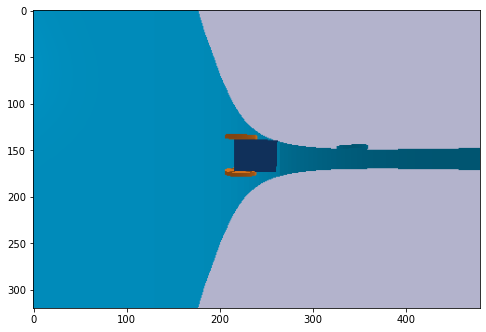

In [25]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

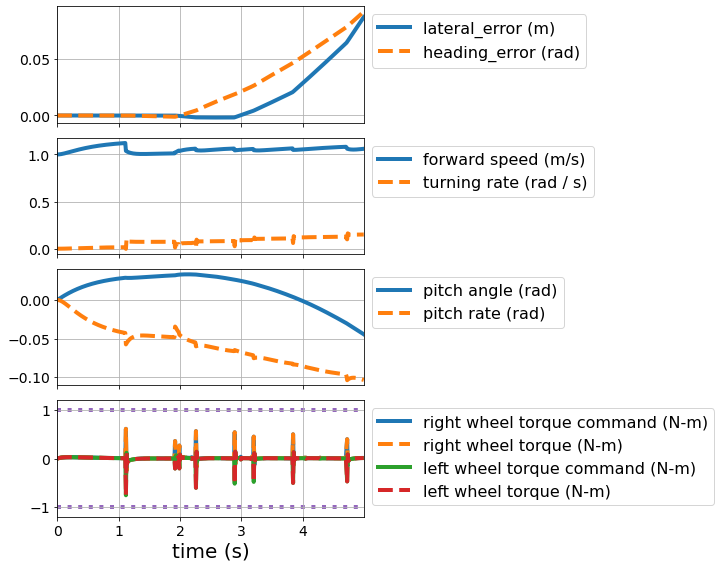

In [26]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

## Plotting deviation for verification ##

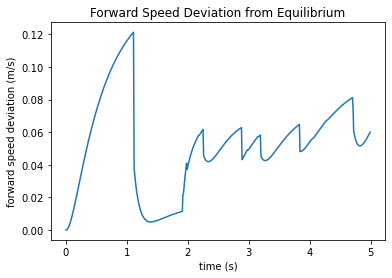

In [27]:
plt.plot(data['t'], data['forward_speed'] - 1)
plt.title('Forward Speed Deviation from Equilibrium')
plt.xlabel('time (s)')
plt.ylabel('forward speed deviation (m/s)')
plt.show()

## Determining Working Limitations ##
Testing the robot with initial velocity at 2 m/s

In [28]:
controller = Controller()
simulator.reset(
    initial_speed=2.,                            
    initial_lateral_error=0.0,
    initial_heading_error=0.,
    initial_pitch=0.0,
    station_velocity= 0.0,
)

In [29]:
controller.reset()
simulator.camera_backview()

In [30]:
data = simulator.run(
    controller,           
    max_time=5.0,         
    data_filename=None,   
    video_filename= None, 
)

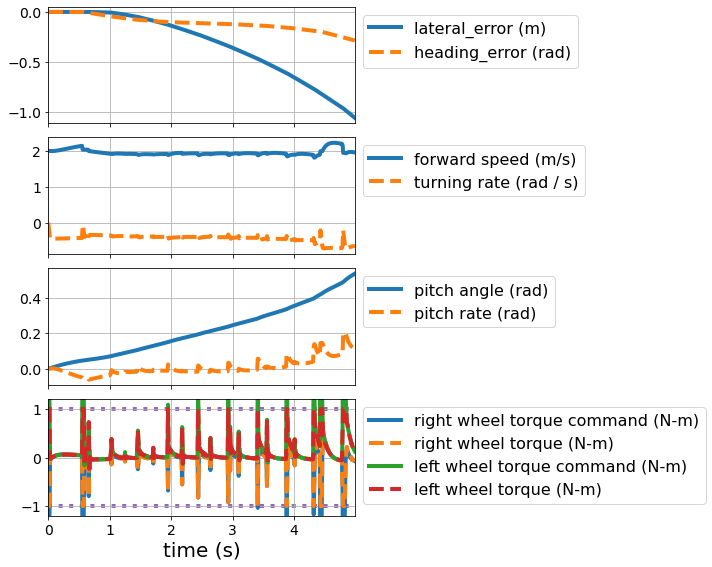

In [31]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Testing the controller with an initial lateral error of 0.5 m

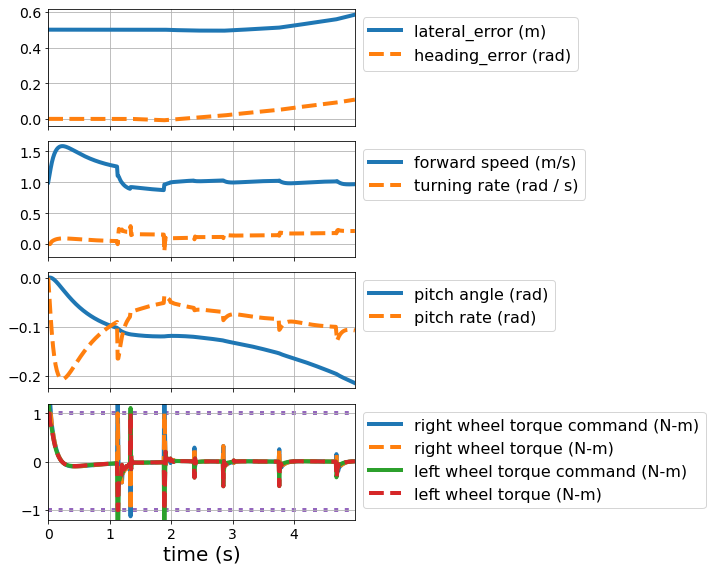

In [32]:
controller = Controller()
simulator.reset(
    initial_speed=1.,                            
    initial_lateral_error=0.5,
    initial_heading_error=0.,
    initial_pitch=0.0,
    station_velocity= 0.0,
)

controller.reset()
simulator.camera_backview()

data = simulator.run(
    controller,           
    max_time=5.0,         
    data_filename=None,   
    video_filename= None, 
)

# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Testing the controller with an initial heading error of 0.5 rad

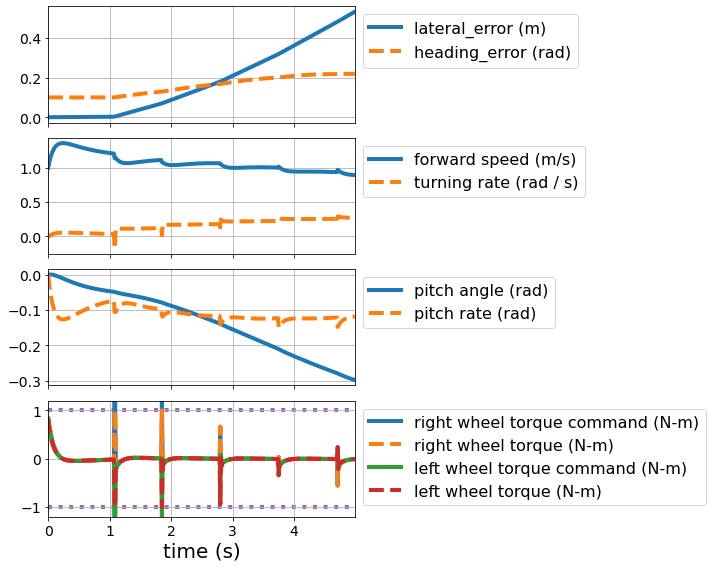

In [35]:
controller = Controller()
simulator.reset(
    initial_speed=1.,                            
    initial_lateral_error=0.0,
    initial_heading_error=0.1,
    initial_pitch=0.0,
    station_velocity= 0.0,
)

controller.reset()
simulator.camera_backview()

data = simulator.run(
    controller,           
    max_time=5.0,         
    data_filename=None,   
    video_filename= None, 
)

# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Testing the controller with an initial pitch angle of 0.3 rad

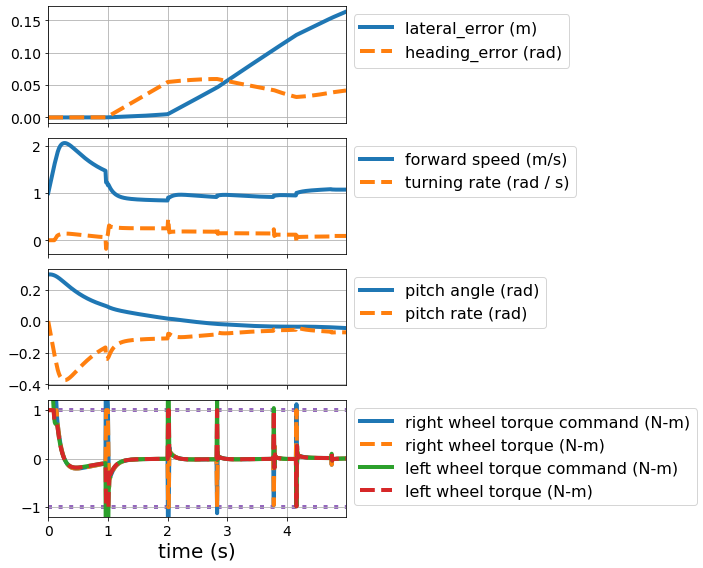

In [34]:
controller = Controller()
simulator.reset(
    initial_speed=1.,                            
    initial_lateral_error=0.0,
    initial_heading_error=0.0,
    initial_pitch=0.3,
    station_velocity= 0.0,
)

controller.reset()
simulator.camera_backview()

data = simulator.run(
    controller,           
    max_time=5.0,         
    data_filename=None,   
    video_filename= None, 
)

# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()